In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2024-05-19 10:32:04.411882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 10:32:04.412079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 10:32:04.610507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base = r"/kaggle/input/leapgestrecog/leapGestRecog"

path = []
label = []

for i in os.listdir(base):
    for j in os.listdir(base + "/"  + i):
        for k in os.listdir(base + "/" + i + "/"  + j):
            curr = base + "/" + i + "/"  + j + "/" + k
            path.append(curr)
            label.append(j[2:])
            
df = pd.DataFrame({'path': path, 'label': label})

In [14]:
df.head()

,path,label
0,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,_l
1,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,_l
2,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,_l
3,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,_l
4,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,_l


['_l' '_fist_moved' '_c' '_down' '_index' '_palm_moved' '_ok' '_thumb'
 '_palm' '_fist']


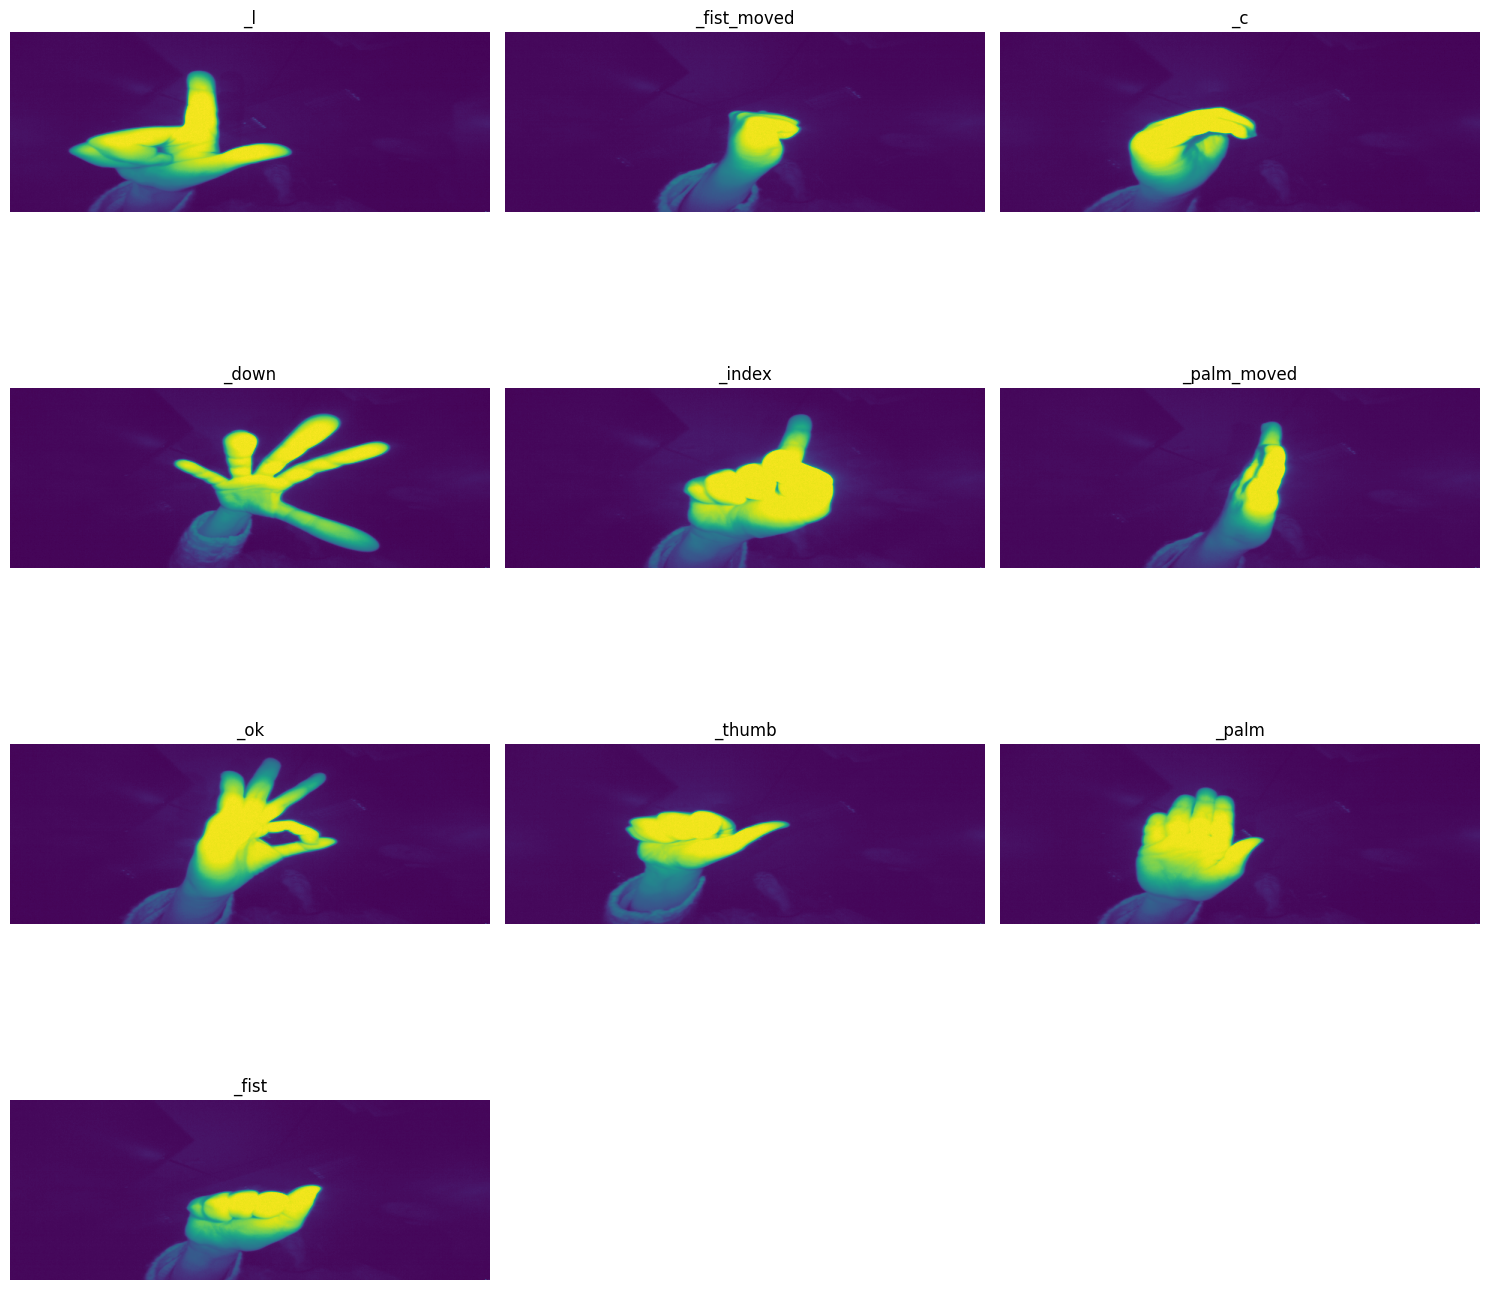

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import math

unique_labels = df['label'].unique()
print(unique_labels)

# Assuming your DataFrame is already loaded
# df = pd.read_csv('your_dataframe.csv')  # Example to load a DataFrame

def display_sample_images(df, grid_size=(3, 3)):
    
    num_labels = len(unique_labels)
    grid_rows, grid_cols = grid_size
    
    # Adjust the grid size if there are more labels than grid slots
    total_slots = grid_rows * grid_cols
    if num_labels < total_slots:
        grid_cols = math.ceil(num_labels / grid_rows)
    
    plt.figure(figsize=(15, 15))
    
    for i, label in enumerate(unique_labels[:total_slots]):
        sample_image_path = df[df['label'] == label].iloc[0]['path']
        img = Image.open(sample_image_path)
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display one sample image for each unique label in a 3x3 grid
display_sample_images(df, grid_size=(4,3))

In [6]:
df.to_csv('data.csv', index=False)

In [7]:
def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image = cv2.resize(image, target_size)  
    image = image / 255.0  
    return image

target_size = (128, 128)

In [8]:
from tqdm import tqdm

X = []
y = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Images"):
    image = preprocess_image(row['path'], target_size)
    label = row['label']
    X.append(image)
    y.append(label)

X = np.array(X)
y = np.array(y)


Processing Images: 100%|██████████| 20000/20000 [02:24<00:00, 138.08it/s]


In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

y_categorical = to_categorical(y_encoded, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=8)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - accuracy: 0.9857 - loss: 0.0420 - val_accuracy: 0.9992 - val_loss: 0.0039
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.9823 - loss: 0.0536 - val_accuracy: 0.9987 - val_loss: 0.0052
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.9865 - loss: 0.0409 - val_accuracy: 0.9992 - val_loss: 0.0028
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.9888 - loss: 0.0392 - val_accuracy: 0.9995 - val_loss: 0.0012
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.9887 - loss: 0.0297 - val_accuracy: 0.9998 - val_loss: 0.0019
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.9847 - loss: 0.0448 - val_accuracy: 0.9992 - val_loss: 0.0046
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.9878 - loss: 0.0390 - val_accuracy: 0.9998 - val_loss: 0.0026
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.9898 -

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9989 - loss: 0.0014


In [17]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = {}
for i in range(num_classes):
    true_positives = np.sum((y_pred_classes == i) & (np.argmax(y_test, axis=1) == i))
    false_positives = np.sum((y_pred_classes == i) & (np.argmax(y_test, axis=1) != i))
    precision[label_encoder.classes_[i]] = true_positives / (true_positives + false_positives)

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


In [18]:
print("Test Accuracy:", test_accuracy)
print("Precision for Each Class:")
for label, prec in precision.items():
    print(f"Precision for {label}: {prec:.4f}")

Test Accuracy: 0.9992499947547913
Precision for Each Class:
Precision for _c: 1.0000
Precision for _down: 1.0000
Precision for _fist: 0.9946
Precision for _fist_moved: 0.9975
Precision for _index: 1.0000
Precision for _l: 1.0000
Precision for _ok: 1.0000
Precision for _palm: 1.0000
Precision for _palm_moved: 1.0000
Precision for _thumb: 1.0000
